In [27]:
using MAT, Statistics, LinearAlgebra,Random, Plots, NonlinearSolve
using StaticArrays, Distributed, SciMLNLSolve, LineSearches
using JLD
include("mvnrnd.jl")

mvnrnd (generic function with 1 method)

In [11]:
function loadInData()
    file = matopen("simulationData.mat")

    data = read(file, "data")

    close(file)

    return data
end

loadInData (generic function with 1 method)

In [12]:
data = loadInData()

grossy = reshape(data[:, 3], 46, 88)'
capital = reshape(data[:, 4], 46, 88)'; #NOMINAL CAPITAL
labor = reshape(data[:, 5], 46, 88)'; #NOMINAL LABOR
vadd = labor + capital; #NOMINAL VALUE;

removableSectors = [60, 80:88...];
grossy = grossy[setdiff(1:end, removableSectors), :];
capital = capital[setdiff(1:end, removableSectors), :];
labor = labor[setdiff(1:end, removableSectors), :];
vadd = vadd[setdiff(1:end, removableSectors), :];

grossSales = vec((sum(grossy, dims=2) .!= 0));
grossy = grossy[grossSales, :];
capital = capital[grossSales, :];
labor = labor[grossSales, :];
vadd = vadd[grossSales, :];


In [13]:
function getVariables(year)
    IO = data[data[:, 1].==year, :]
    temp = [8, 60, 62, 80:88...]
    IO = IO[setdiff(1:end, temp), setdiff(1:end, [1, 2, 3, 4, 5, 94])]
    IO = IO[:, setdiff(1:end, temp)]
    Ω = IO ./ sum(IO, dims=2)
    α = vadd[:, year-1959] ./ grossy[:, year-1959]
    β = ((I - diagm(1 .- α) * Ω)' * grossy[:, year-1959])
    @views β[β.<0] .= 0
    β = β / sum(β)
    λ = (inv(I - diagm(1 .- α) * Ω)' * β)
    L = λ .* α

    return α, β, Ω, L, λ

end

getVariables (generic function with 1 method)

In [14]:
ε = .5;
θ = 0.001;
σ = .9;

In [15]:
function problem(X :: AbstractVector{T}, A, β, Ω, α, ε, θ, σ,L) where T



    N = length(α)
    p = X[1:N]
    y = X[N+1:end]
    
    Out :: Vector{T} = zeros(eltype(X),2*N)
    
    q = (Ω * p .^ (1-θ)) .^ (1 / (1 - θ))
    w = p .* (A .^ ((ε - 1)/ε)) .* (α .^ (1 / ε)) .* (y .^ (1/ε)) .* L .^ (-1/ε)
    C = w' * L
  
    Out[1:N] = p - (A .^ (ε - 1) .* (α .* w .^ (1- ε) + (1 .- α) .* q .^ (1 - ε))) .^ (1/(1-ε))
    Out[N+1:end] = y' - y' * diagm(p)^ε * diagm(A)^(ε-1) * diagm(q)^(θ-ε) * diagm(1 .- α) * Ω * diagm(p)^(-θ) - β'*diagm(p)^(-σ)*C
    
    return Out
end

problem (generic function with 1 method)

In [16]:
function problemJacobian(X, A, β, Ω, α, ε, θ, σ,L)
    N = length(α)
    p = @view X[1:N]
    y = @view X[N+1:end]
    
    Out = zeros(eltype(X),2*N)
    
    q = (Ω * p .^ (1-θ)) .^ (1 / (1 - θ))
    w = p .* (A .^ ((ε - 1)/ε)) .* (α .^ (1 / ε)) .* (y .^ (1/ε)) .* L .^ (-1/ε)
    C = w' * L
  
    
    DQDP = (q .^ θ * (p.^(-θ))') .* Ω;
    DWDP = diagm(A.^((ε-1)/ε) .* α.^(1/ε) .* y.^(1/ε) .* (1 ./ L).^(1/ε));
    DWDY = (1/ε) * diagm(p .* A.^((ε-1)/ε) .* α.^(1/ε).* (y.^(1/ε-1)) .* L.^(-1/ε));
    DCDP = DWDP' * L; 
    DCDY = DWDY' * L;

    DOut1DP = I - diagm(diagm(A)^(-1) * ((α .* (w .^ (1-ε)) + (1 .- α) .* (q.^(1-ε)))).^(ε/(1-ε))) * (diagm(α) * diagm(w.^(-ε))* DWDP + diagm(1 .-α)*diagm(q.^(-ε))*DQDP);

    DOut1DY =  -diagm(diagm(A.^(-1))*((α.*(w.^(1-ε))+(1 .- α).*(q.^(1-ε)))).^(ε/(1-ε)))*(diagm(α)*diagm(w.^(-ε))*DWDY);

    DOut2DP = -(ε * diagm(p.^(-θ))*Ω'*diagm((p.^(ε-1)).*(y).*(q.^(θ-ε)).*(1 .- α).*(A.^(ε-1)))
        + (θ-ε)*diagm(p.^(-θ))*Ω'*diagm((p.^(ε)).*(y).*(q.^(θ-ε-1)).*(1 .- α).*(A.^(ε-1)))*DQDP 
        - σ*diagm(β.*p.^(-σ-1))*C + broadcast(*, β.*(p.^(-σ)), DCDP')
        - θ* diagm(p.^(-θ-1)).*diagm(Ω'*diagm((p.^(ε)).*(q.^(θ-ε)).*(1 .- α).*(A.^(ε-1)))*y));

    DOut2DY = I - (diagm(p)^ε*diagm(A)^(ε-1)*diagm(q)^(θ-ε)*diagm(1 .- α)*Ω*diagm(p)^(-θ))' - broadcast(*, β.*(p.^(-σ)), DCDY');
    OutDeriv = [DOut1DP DOut1DY; DOut2DP DOut2DY];

end

problemJacobian (generic function with 1 method)

In [17]:
trials = 50;
GDP = zeros(trials)
λ = zeros(76,trials)

function f!(F,u,p)
    F[1:152] = problem(u,p,beta,Omega,alpha,ε,θ,σ,L)
end

function j!(J,u,p)
    J[1:152,1:152] = problemJacobian(u,p,beta,Omega,alpha,ε,θ,σ,L)
end

f = NonlinearFunction(f!)

Threads.@threads for k in 1:trials
    
        
    A = exp.(mvnrnd(-1/2*diag(Sigma),diagm(diag(Sigma))));
    
    init = [Complex.(exp.(-inv(I - diagm(1 .- alpha)*Omega)*log.(A)))..., Complex.(domar_weights ./exp.(-inv(I - diagm(1 .- alpha) * Omega)*log.(A)))...];
    
    #init = [exp.(-inv(I - diagm(1 .- alpha)*Omega)*log.(A))..., (domar_weights ./exp.(-inv(I - diagm(1 .- alpha) * Omega)*log.(A)))...]


    p = A

    ProbN = NonlinearProblem(f,init,p)
    sol = solve(ProbN,NLSolveJL(linesearch = HagerZhang(),method = :newton), reltol = 1e-8,abstol = 1e-8)

    x = sol.u
    println("solv")

    GDP[k] = (x[1:76] .* (A .^ ((ε-1)/ε)).*(alpha.^(1/ε)).*(x[77:152].^(1/ε)).* L .^ (-1/ε))' * L;
    λ[:,k] = (x[1:76] .* x[77:end]) / GDP[k] 


        
end

TaskFailedException: TaskFailedException

    nested task error: UndefVarError: Sigma not defined
    Stacktrace:
     [1] macro expansion
       @ ~/Schreibtisch/BeyondHulten/Translation/OtherSolver.ipynb:18 [inlined]
     [2] (::var"#71#threadsfor_fun#16"{var"#71#threadsfor_fun#15#17"{UnitRange{Int64}}})(tid::Int64; onethread::Bool)
       @ Main ./threadingconstructs.jl:84
     [3] #71#threadsfor_fun
       @ ./threadingconstructs.jl:51 [inlined]
     [4] (::Base.Threads.var"#1#2"{var"#71#threadsfor_fun#16"{var"#71#threadsfor_fun#15#17"{UnitRange{Int64}}}, Int64})()
       @ Base.Threads ./threadingconstructs.jl:30

In [18]:
function shockSectorProgressively(sector, shocks, year=1983)

    (α, β, Ω, L, λ) = getVariables(year)

    x0 = Complex.([ones(76)..., λ...])
    f = NonlinearFunction((u, p) -> problem(u, p...), jac=(u, p) -> problemJacobian(u, p...))
    GDP = []
    for shock in shocks
        A = ones(76)
        A[sector] = shock




        p = [A, β, Ω, α, ε, θ, σ, L]
        ProbN = NonlinearProblem(f, x0, p)

        #sol = solve(ProbN,NewtonRaphson(), reltol = 1e-10,abstol = 1e-8)
        sol = solve(ProbN, NLSolveJL(method=:newton, linesearch=BackTracking()), reltol=1e-10, abstol=1e-8)

        x = sol.u

        p = real.(x[1:76])
        y = real.(x[77:152])
        append!(GDP, (p .* (A .^ ((ε - 1) / ε)) .* (α .^ (1 / ε)) .* (y .^ (1 / ε)) .* L .^ (-1 / ε))' * L)

        x0 = x
    end

    return GDP

end

shockSectorProgressively (generic function with 2 methods)

In [19]:
years = 1980:2000
M = 50

a = 0.7;
b = 1.3;

sectors = 1:60

GDP = zeros(2 * M, length(sectors), length(years))

@distributed for year in years
    for i in 1:length(sectors)
        GDP[1:M, i, year-(years[1]-1)] = shockSectorProgressively(sectors[i], LinRange(1, a, M), year)
        GDP[M+1:end, i, year-(years[1]-1)] = shockSectorProgressively(sectors[i], LinRange(1, b, M), year)
    end
end


Task (done) @0x00007efda8bd9b60

In [20]:

@views reverse!(GDP[1:M, :,:], dims=1)
GDP = GDP[setdiff(1:end, M), :,:]

99×60×21 Array{Float64, 3}:
[:, :, 1] =
 0.960047  0.995523  0.996884  0.986077  …  0.985263  0.951592  0.994301
 0.961356  0.995752  0.997038  0.986849     0.985702  0.953062  0.994458
 0.962633  0.99597   0.997183  0.987589     0.986132  0.954501  0.994612
 0.963879  0.996178  0.997321  0.988298     0.986553  0.955911  0.994764
 0.965095  0.996377  0.997452  0.988976     0.986966  0.957292  0.994914
 0.966281  0.996566  0.997576  0.989626  …  0.98737   0.958645  0.995061
 0.96744   0.996747  0.997694  0.990247     0.987767  0.959972  0.995206
 0.968572  0.996919  0.997806  0.990841     0.988156  0.961272  0.99535
 0.969677  0.997083  0.997912  0.991408     0.988538  0.962547  0.995491
 0.970757  0.99724   0.998014  0.99195      0.988913  0.963798  0.99563
 ⋮                                       ⋱                      
 1.01562   1.00062   1.00065   1.00049   …  1.00713   1.02218   1.00302
 1.01591   1.00063   1.00066   1.0005       1.00727   1.02262   1.00309
 1.0162    1.00063   1.

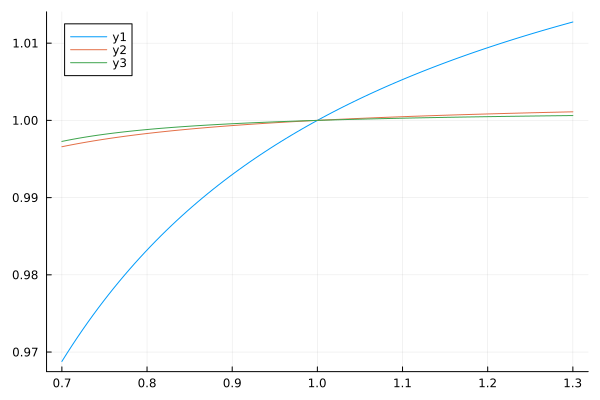

In [21]:
plot(LinRange(a,b,2*M-1),GDP[:,1,4])
plot!(LinRange(a,b,2*M-1),GDP[:,2,4])
plot!(LinRange(a,b,2*M-1),GDP[:,3,4])

In [28]:
save("calulatedGSPS.jld","GDP",GDP)

In [29]:
GDP = load("calulatedGSPS.jld","GDP")

99×60×21 Array{Float64, 3}:
[:, :, 1] =
 0.960047  0.995523  0.996884  0.986077  …  0.985263  0.951592  0.994301
 0.961356  0.995752  0.997038  0.986849     0.985702  0.953062  0.994458
 0.962633  0.99597   0.997183  0.987589     0.986132  0.954501  0.994612
 0.963879  0.996178  0.997321  0.988298     0.986553  0.955911  0.994764
 0.965095  0.996377  0.997452  0.988976     0.986966  0.957292  0.994914
 0.966281  0.996566  0.997576  0.989626  …  0.98737   0.958645  0.995061
 0.96744   0.996747  0.997694  0.990247     0.987767  0.959972  0.995206
 0.968572  0.996919  0.997806  0.990841     0.988156  0.961272  0.99535
 0.969677  0.997083  0.997912  0.991408     0.988538  0.962547  0.995491
 0.970757  0.99724   0.998014  0.99195      0.988913  0.963798  0.99563
 ⋮                                       ⋱                      
 1.01562   1.00062   1.00065   1.00049   …  1.00713   1.02218   1.00302
 1.01591   1.00063   1.00066   1.0005       1.00727   1.02262   1.00309
 1.0162    1.00063   1.

In [31]:
using GLMakie


fig = Figure()

#sl_x = Slider(fig[1, 1], range = 1980:2000, startvalue = 1980)
#sl_x2 = Slider(fig[2,1],range = 1:60, startvalue = 7)
ax = Axis(fig[2, 1])

sg = SliderGrid(fig[1, 1],
    (label = "Year", range = 1980:2000, startvalue = 5),
    (label = "Sector", range = 1:60, startvalue = 10)
)


indexYear = lift(sg.sliders[1].value) do x
    x - 1979 
end

indexSector = lift(sg.sliders[2].value) do x
    x
end

lineShowing = @lift(GDP[:,$indexSector,$indexYear])

lines!(LinRange(a,b,2*M-1),lineShowing)

fig